In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas
import matplotlib.pylab as plt
import os
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

from tqdm import tqdm
from dataSet import *
from unet_model import *
from torch.utils.data import DataLoader, random_split
from diceCoefficient import *

In [2]:
# Change these directories as needed

# Image Directories 
# image
dir_image='/home/matmatius/Desktop/otsuImages/originalrgb/'
# mask
dir_mask='/home/matmatius/Desktop/otsuImages/masksrgb/'
# scale image

In [3]:
dataset=Dataset(dir_image,dir_mask)

In [4]:
train_loader=torch.utils.data.DataLoader(dataset=dataset, batch_size=len(dataset))

In [5]:
Y=list(train_loader)[0]['image']
Y.shape

torch.Size([118, 1, 128, 128])

In [6]:
#index =101

def plotImageHist(index):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].hist(Y[index,0].view(1,-1))
    axs[0].set_xlabel('intensitiy')
    axs[0].set_ylabel('frequencies')
    axs[0].set_title('histogram')
    axs[1].imshow(Y[index,0],cmap='gray')
    axs[1].set_title('image')

# Histograms of intensities of images.

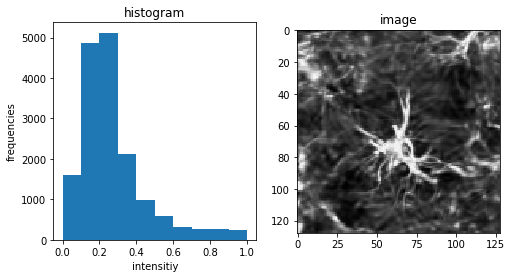

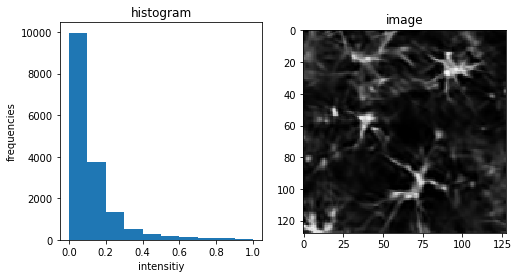

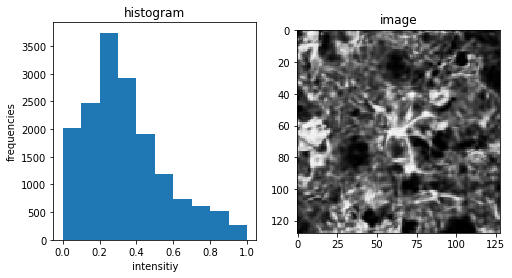

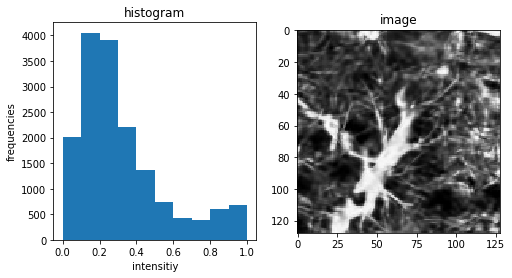

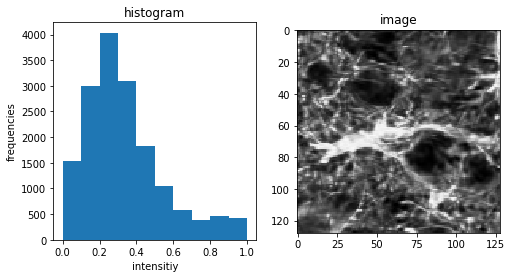

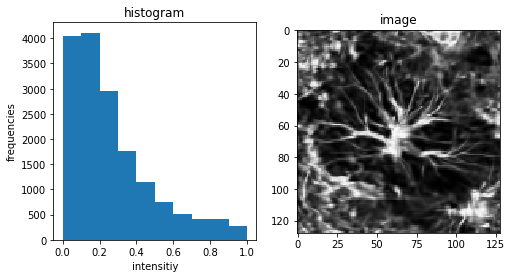

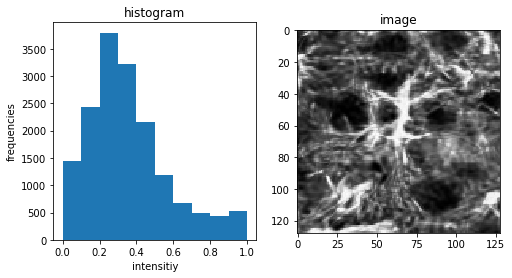

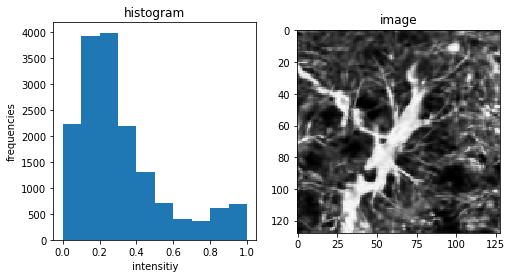

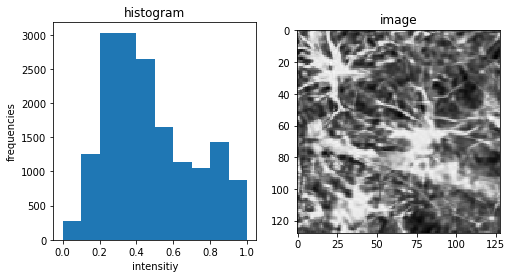

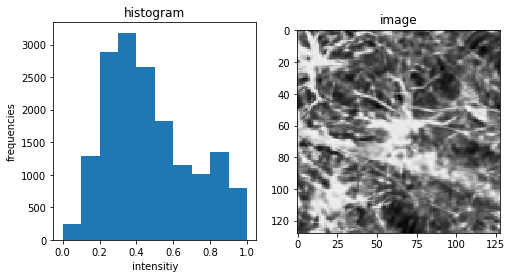

In [7]:
for i in range(10):
    plotImageHist(10*i)

# Average of intensities  of images.

In [8]:
average=torch.sum(Y,dim=0)/118
average.shape

torch.Size([1, 128, 128])

# Histogram of Average of intensities.

Text(0.5, 1.0, 'gray image')

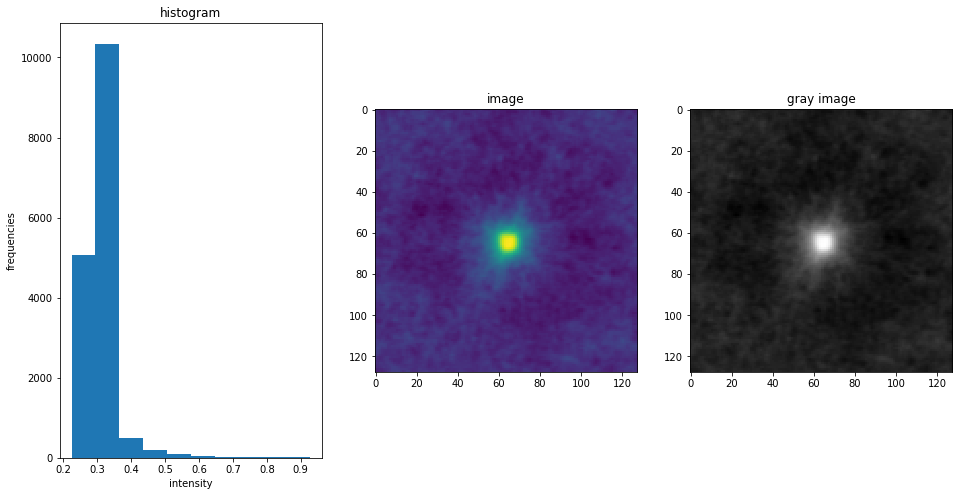

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].hist(average[0].view(1,-1))
axs[0].set_xlabel('intensity')
axs[0].set_ylabel('frequencies')
axs[0].set_title('histogram')
axs[1].imshow(average[0])#,cmap='gray')

axs[1].set_title('image')
axs[2].imshow(average[0],cmap='gray')
axs[2].set_title('gray image')

# UNet structure

In [10]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F

from unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64 * factor, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    def forwardInc(self,x):
        x1 = self.inc(x)
        return x1
    def forwardDown1(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        return x2
    def forwardDown2(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        return x3
    
    def forwardDown3(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        return x4
    
    def forwardDown4(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        return x5
    
    def forwardUp1(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        return x
    
    def forwardUp2(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        return x
    
    def forwardUp3(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        
        return x
    
    def forwardUp4(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return x
    
    


In [11]:
model=UNet(1,2,bilinear=False)

In [12]:
model.load_state_dict(torch.load('/home/matmatius/Desktop/astrocyteSegmentation/trainedUNetNoBilinear.pt'))

<All keys matched successfully>

In [13]:
Y[0]

tensor([[[0.1490, 0.1647, 0.1882,  ..., 0.1882, 0.2745, 0.3216],
         [0.2196, 0.2078, 0.2353,  ..., 0.2863, 0.2941, 0.4353],
         [0.2863, 0.2941, 0.2902,  ..., 0.2706, 0.2941, 0.3922],
         ...,
         [0.8314, 0.8745, 0.7922,  ..., 0.2078, 0.1686, 0.1569],
         [0.8275, 0.8824, 0.6549,  ..., 0.2078, 0.1765, 0.1569],
         [0.8078, 0.8275, 0.5098,  ..., 0.2353, 0.2157, 0.1725]]],
       dtype=torch.float64)

# Shape of output of each layer

# first layer

In [14]:
inc=model.forwardInc(Y[0].view(-1,1,128,128).float())
inc.shape
#plt.hist(inc.view(1,-1).detach().numpy())

torch.Size([1, 64, 128, 128])

# down1 layer

In [15]:
down1=model.forwardDown1(Y[0].view(-1,1,128,128).float())
down1.shape

torch.Size([1, 128, 64, 64])

# down2 layer

In [16]:
down2=model.forwardDown2(Y[0].view(-1,1,128,128).float())
down2.shape

torch.Size([1, 256, 32, 32])

# down3 layer

In [17]:
down3=model.forwardDown3(Y[0].view(-1,1,128,128).float())
down3.shape

torch.Size([1, 512, 16, 16])

# down4 layer

In [18]:
down4=model.forwardDown4(Y[0].view(-1,1,128,128).float())
down4.shape

torch.Size([1, 1024, 8, 8])

# up1 layer

In [19]:
up1=model.forwardUp1(Y[0].view(-1,1,128,128).float())
up1.shape

torch.Size([1, 512, 16, 16])

# up2 layer

In [20]:
up2=model.forwardUp2(Y[0].view(-1,1,128,128).float())
up2.shape

torch.Size([1, 256, 32, 32])

# up3 layer

In [21]:
up3=model.forwardUp3(Y[0].view(-1,1,128,128).float())
up3.shape

torch.Size([1, 128, 64, 64])

# up3 layer

In [22]:
up4=model.forwardUp4(Y[0].view(-1,1,128,128).float())
up4.shape

torch.Size([1, 64, 128, 128])

# output layer

In [23]:
out=model.forward(Y[0].view(-1,1,128,128).float())
out.shape

torch.Size([1, 2, 128, 128])

# Convolution in Pytorch

# Multiple input multiple output channels

Sample taken from coursera.

Two input channels and three output channels



<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2mulit_input_output.png" width = 750, align = "center">

The output of the first channel is given by: 
<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_%20multi_channel_1.png" width = 750, align = "center">

The output of the second channel is given by:

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_%20multi_channel_2.png" width = 750, align = "center">

The output of the last channel is given by:

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_%20multi_channel_3.png" width = 750, align = "center">

In [24]:
# code iplementation

import torch.nn as nn

conv = nn.Conv2d(in_channels=2, out_channels=3,kernel_size=3)
conv.state_dict()['weight'][0][0]=torch.tensor([[0.0,0.0,0.0],[0,0.5,0],[0.0,0.0,0.0]])
conv.state_dict()['weight'][0][1]=torch.tensor([[0.0,0.0,0.0],[0,0.5,0],[0.0,0.0,0.0]])


conv.state_dict()['weight'][1][0]=torch.tensor([[0.0,0.0,0.0],[0,1,0],[0.0,0.0,0.0]])
conv.state_dict()['weight'][1][1]=torch.tensor([[0.0,0.0,0.0],[0,-1,0],[0.0,0.0,0.0]])

conv.state_dict()['weight'][2][0]=torch.tensor([[1.0,0,-1.0],[2.0,0,-2.0],[1.0,0.0,-1.0]])
conv.state_dict()['weight'][2][1]=torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


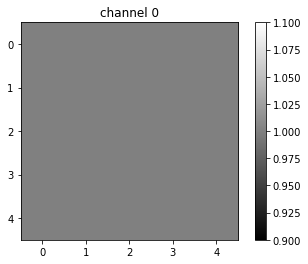

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


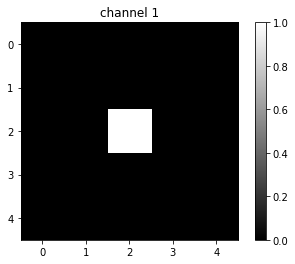

In [25]:
image4=torch.zeros(1,2,5,5)
image4[0][0]=torch.ones(5,5)
image4[0][1][2][2]=1
for channel,image in enumerate(image4[0]):
    plt.imshow(image.detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    print(image)
    plt.title("channel {}".format(channel))
    plt.colorbar()
    plt.show()

In [26]:
z=conv(image4)
z

tensor([[[[ 0.5008,  0.5008,  0.5008],
          [ 0.5008,  1.0008,  0.5008],
          [ 0.5008,  0.5008,  0.5008]],

         [[ 1.2288,  1.2288,  1.2288],
          [ 1.2288,  0.2288,  1.2288],
          [ 1.2288,  1.2288,  1.2288]],

         [[-1.1075, -2.1075, -1.1075],
          [-0.1075, -0.1075, -0.1075],
          [ 0.8925,  1.8925,  0.8925]]]], grad_fn=<MkldnnConvolutionBackward>)